In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

from VQLSSVM import VQLSSVM

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

np.set_printoptions(precision=4, suppress=True)

In [2]:
shots: int = 10000
gamma: float = 0.01 # regularization parameter
subsetSize: int = 7
classToFilterOut: int = 2

In [3]:
def prepareDataset(normalizeValues: bool = False, dataset: str = "iris") -> (np.ndarray, np.ndarray, np.array, np.array):
    if dataset == "iris":
        X,y = datasets.load_iris(return_X_y=True)
        X = X[y!=classToFilterOut]
        y = y[y!=classToFilterOut]
    elif dataset == "breastCancer":
        X,y = datasets.load_breast_cancer(return_X_y=True)
    elif dataset == "dummyData":
        X, y = datasets.make_classification(
            n_samples=50, n_features=2, n_informative=2, n_redundant=0, random_state=45
        )
    elif dataset == "digits":
        X, y = datasets.load_digits(n_class=2, return_X_y=True)
    elif dataset == "wine":
        X, y = datasets.load_wine(return_X_y=True) # 3 classes; filter out some class
    else: 
        raise ValueError("Dataset not yet implemented")
    y: np.array = np.where(y == 0, -1, 1) # might cause some problems in a future

    if normalizeValues: # normalize values returns nan with digits dataset
        max = np.max(X, axis=0)
        min = np.min(X, axis=0)
        X = (2*X - min - max) / (max - min)
    return train_test_split(X, y, test_size=(X.shape[0]-subsetSize)/(X.shape[0]), random_state=43)

In [4]:
xTrain, xTest, yTrain, yTest = prepareDataset(normalizeValues=True, dataset="iris")
print(xTrain)

[[ 0.5556  0.      0.7073  0.6471]
 [-0.1852  0.5833 -0.8537 -0.6471]
 [ 0.7037 -0.25    0.7561  0.4118]
 [-0.4074  0.4167 -0.7561 -0.6471]
 [-0.4815  0.0833 -0.8049 -0.8824]
 [-0.037  -0.25    0.2683  0.4118]
 [ 0.4074 -0.8333  0.7073  0.6471]]


# VQLS-LSSVM state vectors

Condition number of the matrix:  1549.1963269879666
LS-SVM Matrix:
 [[  0.       1.       1.       1.       1.       1.       1.       1.    ]
 [  1.     101.2276  -1.1254   1.1922  -1.1798  -1.4077   0.4356   1.1453]
 [  1.      -1.1254 101.522   -1.188    1.3826   1.3958  -0.6344  -1.584 ]
 [  1.       1.1922  -1.188  101.2989  -1.229   -1.3315   0.4088   1.2963]
 [  1.      -1.1798   1.3826  -1.229  101.33     1.4104  -0.5584  -1.4667]
 [  1.      -1.4077   1.3958  -1.3315   1.4104 101.6651  -0.5823  -1.4058]
 [  1.       0.4356  -0.6344   0.4088  -0.5584  -0.5823 100.3054   0.6494]
 [  1.       1.1453  -1.584    1.2963  -1.4667  -1.4058   0.6494 101.7794]]
['III', 'IIX', 'IIZ', 'IXI', 'IXX', 'IXZ', 'IYY', 'IZI', 'IZX', 'IZZ',
 'XII', 'XIX', 'XIZ', 'XXI', 'XXX', 'XXZ', 'XYY', 'XZI', 'XZX', 'XZZ',
 'YIY', 'YXY', 'YYI', 'YYX', 'YYZ', 'YZY', 'ZII', 'ZIX', 'ZIZ', 'ZXI',
 'ZXX', 'ZXZ', 'ZYY', 'ZZI', 'ZZX', 'ZZZ']
Pauli matrix coeffitients [(88.64105774546628+0j), (0.4679490309569777+0j),

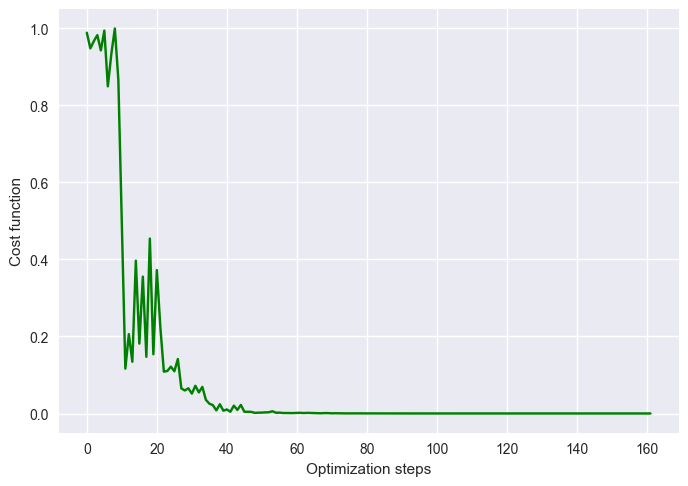

In [5]:
vqlssvmVectors: VQLSSVM = VQLSSVM(gamma, shots)
vqlssvmVectors.train(xTrain, yTrain, quantumSimulation=False, verbose=True, iterations = 200, method="COBYLA")

vqlssvmVectors.plotCost()

In [6]:
costCOBYLA = vqlssvmVectors.getCostHistory()
print("Cost history:")
print(costCOBYLA)

Cost history:
[0.9885826076665506, 0.9478939715467656, 0.9666505066618117, 0.9822942834146542, 0.9427105190825626, 0.9939692552983843, 0.8493489811980662, 0.9334906433859553, 0.9995613107061894, 0.8664129018163579, 0.49688084888284667, 0.11662257043192759, 0.2061070063054966, 0.13432571836236218, 0.39683601608934294, 0.18149652307448327, 0.35534215090454957, 0.1472628421216835, 0.45417015848205056, 0.15389205951446672, 0.3722656162264062, 0.22383612918537799, 0.10867031660621473, 0.11045442951284834, 0.12159747245288233, 0.10969272911586614, 0.14140364995621013, 0.06517646471569538, 0.059796610277498496, 0.06548381501371181, 0.05166176560701419, 0.07199947177507449, 0.05479018659506396, 0.06903905864770254, 0.03563893506539395, 0.025486153532092604, 0.021682483200991753, 0.008173667398493123, 0.024053599292234384, 0.007283973394314414, 0.010531753035016522, 0.004574449754420673, 0.020374605425335424, 0.009367422529099056, 0.022276102094084704, 0.004552743741780274, 0.0046010737079063, 

In [7]:
print(vqlssvmVectors.predict(xTest))

[-0.0724+0.j -0.1282+0.j -0.0066+0.j -0.1225+0.j -0.0624+0.j  0.0817+0.j
 -0.0012+0.j  0.0455+0.j -0.1042+0.j -0.0081+0.j -0.1215+0.j -0.1523+0.j
  0.102 +0.j -0.0911+0.j  0.0055+0.j -0.1675+0.j -0.0393+0.j -0.1254+0.j
  0.0418+0.j  0.0861+0.j -0.0524+0.j -0.1343+0.j  0.0731+0.j  0.0264+0.j
 -0.0999+0.j  0.0206+0.j  0.068 +0.j  0.1176+0.j  0.0799+0.j -0.0701+0.j
 -0.1542+0.j -0.0375+0.j -0.126 +0.j -0.069 +0.j -0.0393+0.j -0.0626+0.j
  0.0666+0.j -0.093 +0.j -0.0948+0.j -0.1157+0.j  0.002 +0.j -0.0791+0.j
 -0.0342+0.j -0.1425+0.j -0.014 +0.j  0.1226+0.j -0.0703+0.j  0.0203+0.j
 -0.0833+0.j -0.0638+0.j -0.0948+0.j  0.105 +0.j  0.0411+0.j  0.0381+0.j
 -0.0862+0.j  0.0951+0.j  0.049 +0.j -0.1188+0.j -0.1144+0.j -0.0729+0.j
 -0.178 +0.j  0.0801+0.j -0.1316+0.j -0.0213+0.j -0.0044+0.j  0.1353+0.j
  0.0639+0.j -0.0977+0.j -0.0913+0.j  0.033 +0.j  0.1383+0.j -0.0686+0.j
  0.0224+0.j -0.0712+0.j  0.0775+0.j -0.0578+0.j -0.1298+0.j  0.1114+0.j
 -0.0752+0.j -0.091 +0.j  0.0187+0.j  0.0494+0.j -0

In [8]:
print("Accuracy:",vqlssvmVectors.accuracy(xTest, yTest))

Accuracy: 0.9032258064516129


# VQLS-LSSVM quantum

Condition number of the matrix:  1549.1963269879666
LS-SVM Matrix:
 [[  0.       1.       1.       1.       1.       1.       1.       1.    ]
 [  1.     101.2276  -1.1254   1.1922  -1.1798  -1.4077   0.4356   1.1453]
 [  1.      -1.1254 101.522   -1.188    1.3826   1.3958  -0.6344  -1.584 ]
 [  1.       1.1922  -1.188  101.2989  -1.229   -1.3315   0.4088   1.2963]
 [  1.      -1.1798   1.3826  -1.229  101.33     1.4104  -0.5584  -1.4667]
 [  1.      -1.4077   1.3958  -1.3315   1.4104 101.6651  -0.5823  -1.4058]
 [  1.       0.4356  -0.6344   0.4088  -0.5584  -0.5823 100.3054   0.6494]
 [  1.       1.1453  -1.584    1.2963  -1.4667  -1.4058   0.6494 101.7794]]
['III', 'IIX', 'IIZ', 'IXI', 'IXX', 'IXZ', 'IYY', 'IZI', 'IZX', 'IZZ',
 'XII', 'XIX', 'XIZ', 'XXI', 'XXX', 'XXZ', 'XYY', 'XZI', 'XZX', 'XZZ',
 'YIY', 'YXY', 'YYI', 'YYX', 'YYZ', 'YZY', 'ZII', 'ZIX', 'ZIZ', 'ZXI',
 'ZXX', 'ZXZ', 'ZYY', 'ZZI', 'ZZX', 'ZZZ']
Pauli matrix coeffitients [(88.64105774546628+0j), (0.4679490309569777+0j),

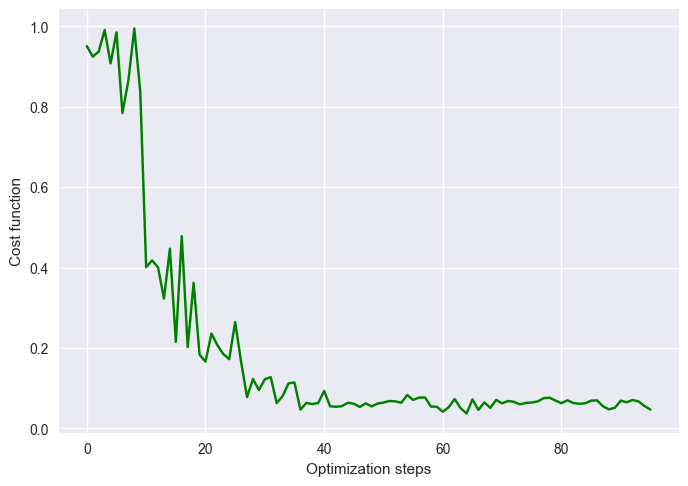

In [9]:
vqlssvmQuantum: VQLSSVM = VQLSSVM(gamma, shots)
vqlssvmQuantum.train(xTrain, yTrain, quantumSimulation=True, verbose=True, iterations = 200)

vqlssvmQuantum.plotCost()

In [10]:
costCOBYLA = vqlssvmQuantum.getCostHistory()
print("Cost history:")
print(costCOBYLA)

import csv

with open('costCOBYLA.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Iteration', 'CostFunction'])
    for i in range(len(costCOBYLA)):
        writer.writerow([i, costCOBYLA[i]])


Cost history:
[0.9510040347403907, 0.9248084220405627, 0.9373258505526088, 0.9911091026917361, 0.9081027247270498, 0.9852276256237273, 0.7845799798570581, 0.8651402719790756, 0.9948965218318542, 0.8385690606281423, 0.4010789182529342, 0.4179836497241054, 0.40063126759513323, 0.3228118422761673, 0.4470514465815534, 0.21533496191780888, 0.4781687758294476, 0.2022468800645908, 0.36217417265433016, 0.18329375750752452, 0.16611108137606, 0.23592601173493444, 0.20700842998025282, 0.18513004325604587, 0.17215479877611017, 0.26446422299952643, 0.1658290214309981, 0.07790879020480801, 0.12302697753191316, 0.09523971378148932, 0.12241178609441983, 0.12741899323499462, 0.06294082381465371, 0.08045279514479131, 0.1121122051935669, 0.11402016961010364, 0.04659030670113906, 0.06336058148634272, 0.06053650663546317, 0.0632252190768734, 0.09323967268497646, 0.05513126034866411, 0.053808685900076036, 0.05529071227336191, 0.06375438605300554, 0.06136152740802736, 0.05332605003351387, 0.06219332447296855

In [11]:
print("Predictions:\n", vqlssvmQuantum.predict(xTest))
print("Accuracy: ", vqlssvmQuantum.accuracy(xTest, yTest))

Predictions:
 [-0.0737+0.j -0.0956+0.j -0.0902+0.j -0.1148+0.j -0.0072+0.j  0.0467+0.j
  0.024 +0.j  0.0362+0.j -0.0922+0.j  0.0134+0.j -0.0863+0.j -0.0985+0.j
  0.037 +0.j -0.0905+0.j  0.0288+0.j -0.108 +0.j -0.0813+0.j -0.0828+0.j
  0.0222+0.j  0.0673+0.j -0.083 +0.j -0.0884+0.j  0.0474+0.j  0.0302+0.j
 -0.1015+0.j  0.0316+0.j  0.0434+0.j  0.0518+0.j  0.0513+0.j -0.0945+0.j
 -0.0939+0.j -0.098 +0.j -0.0828+0.j -0.0937+0.j -0.0884+0.j -0.0018+0.j
  0.0483+0.j -0.0859+0.j -0.0864+0.j -0.0988+0.j  0.0421+0.j -0.0709+0.j
 -0.0732+0.j -0.1038+0.j  0.0219+0.j  0.0653+0.j -0.072 +0.j  0.0253+0.j
 -0.0858+0.j -0.0856+0.j -0.0924+0.j  0.051 +0.j  0.0276+0.j  0.0203+0.j
 -0.0811+0.j  0.0658+0.j  0.0374+0.j -0.0897+0.j -0.0761+0.j -0.0781+0.j
 -0.0745+0.j  0.0741+0.j -0.0918+0.j  0.0171+0.j  0.0341+0.j  0.0795+0.j
  0.0361+0.j -0.0887+0.j -0.0851+0.j  0.0283+0.j  0.0747+0.j -0.0883+0.j
  0.027 +0.j  0.01  +0.j  0.0489+0.j -0.1045+0.j -0.0964+0.j  0.0752+0.j
 -0.0815+0.j -0.0959+0.j  0.0312+0.j 

# LSSVM (work in progresss)

In [17]:
# lssvmMatrix1: np.ndarray = lssvmMatrix(xTrain, gamma, "linearKernel")
# yVector: np.array = prepareLabels(yTrain)
# print(yVector)
# print ("Condition number of the matrix: ", np.linalg.cond(lssvmMatrix1))
# print("LS-SVM Matrix:\n", lssvmMatrix1)
# print(yVector)

# solution: np.array = np.linalg.solve(lssvmMatrix1, yVector)
# print("Solution:", solution)
# print ("Norm of the solution: ",solution/np.linalg.norm(solution))

# bias: float = solution[0]
# weights: np.array = solution[1:]

# vqlssvmLSSVM: VQLSSVM = VQLSSVM(gamma,10)
# vqlssvmLSSVM.xTrain = xTrain
# vqlssvmLSSVM.xTrainSize = xTrain.shape[0]
# vqlssvmLSSVM.weights = weights
# vqlssvmLSSVM.b = bias
# predictions: np.array = vqlssvmLSSVM.predict(xTest)
# classVals = [vqlssvmLSSVM.assignClass(i) for i in predictions]
# print("Predictions:", predictions)
# print("Class values:", classVals)
# print("yTest:", yTest)
# # print(yTest)
# print("Accuracy:", vqlssvmLSSVM.accuracy(xTest, yTest))

# Classical SVM

In [18]:
clf = SVC(kernel='linear')
clf.fit(xTrain, yTrain)
yPred = clf.predict(xTest)
print("Accuracy:", accuracy_score(yTest, yPred))

Accuracy: 1.0
